# Deep Learning on Graph Data:

In this presentation we use Tensorflow to perform optimizations on a randomly generated input graph. 

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import itertools as it

In [2]:
# create new session if we need it
sess = tf.Session()

In [4]:
def gen_rand_graph(n=15, p=0.3):
    # Modelling the resource allocation with Normal Distrib - mean: m, and stddev = s
    m = 20
    s = 0.25

    sess.run(tf.global_variables_initializer())
    G_rand = nx.duplication_divergence_graph(n, p, 1)

    # add tf risk constants and variables to each node
    for node, data in G_rand.nodes_iter(data=True):
        data['risk'] = tf.constant(np.random.uniform(0,1))
        data['risk_A'] = np.random.uniform(0,1)
        data['risk_B'] = np.random.uniform(0.5,1.5)
        data['allocation'] = tf.Variable(tf.random_normal([1,1], mean = m, stddev=s))

    return G_rand

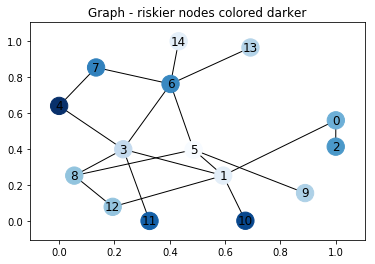

In [15]:
graph = gen_rand_graph()

color_values = [sess.run(data['risk']) for node, data in graph.nodes_iter(data=True)]

pos = nx.spring_layout(graph)
nx.draw_networkx_nodes(graph, pos, cmap=plt.cm.Blues, node_color = color_values)
nx.draw_networkx_edges(graph, pos, arrows=True)
nx.draw_networkx_labels(graph,pos)
plt.title('Graph - riskier nodes colored darker')
plt.show()

In [16]:
def query2(G, alpha=tf.constant(0.0)):
    allocation_sumexp = tf.constant(0.0)
    risk_sum = tf.constant(0.0)
    
    for node, data in G.nodes_iter(data=True):
        allocation_sumexp += tf.exp(data['allocation'])
        risk_sum += data['risk']
    
    cost = tf.constant(0.0)
    
    for i in nx.dfs_preorder_nodes(G, 0):
        node = G.node[i]
        softmax_allocation = tf.exp(node['allocation'])/allocation_sumexp
        normalized_risk = tf.exp(node['risk'])/risk_sum
        node['softmax_allocation'] = softmax_allocation
        cost += normalized_risk*softmax_allocation + alpha*node['softmax_allocation']**2
        
#         print G.neighbors(i)
        for neighbor in G.neighbors(i):
#             print G.node[neighbor]
            cost += 0.25 * G.node[neighbor]['risk'] * softmax_allocation / risk_sum

    return cost

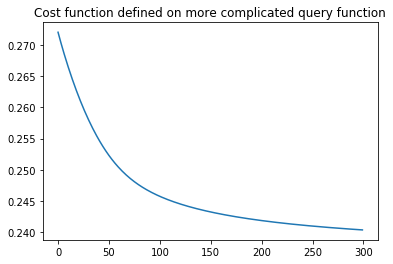

In [17]:
def test_query(graph, query, train_steps=100):
    learning_rate = 1.0
    alpha = tf.constant(0.2)
    cost = query(graph, alpha)
    optimizer = tf.train.AdagradOptimizer(learning_rate)
    train = optimizer.minimize(cost)
    #reinitialise everything
    sess.run(tf.global_variables_initializer())
    #Now optimize with this form
    cost_tracker = np.zeros([train_steps])
    for step in range(train_steps):
        sess.run(train)

        cost_tracker[step] = sess.run(cost)
    plt.plot(cost_tracker)
    plt.title("Cost function defined on more complicated query function")

test_query(graph, query2, train_steps=300)

In [18]:
# Convert graph to tensor form
def convert(G, d):
    x = np.zeros((d,2))
    ind = 0
    for i in nx.dfs_preorder_nodes(G, 0):
        node = G.node[i]
        x[ind,0] = node['risk_A']
        x[ind,1] = node['risk_B']
        ind += 1
        
    
    x = np.divide(x.astype('float'),np.sum(x,0))
    return x

x = convert(graph, 20)

#reinitialise everything

In [5]:
# generate some graphs
graphs = []
d = 2
N = 5

for i in range(10):
    nodes = np.random.randint(2, N+1)
    graphs.append(gen_rand_graph(n=nodes))

In [6]:
# Construct query
# tf Graph Input
X = tf.placeholder("float", shape=(N,d))

# Set model weights
w = tf.Variable(tf.random_normal([1,d]), name="weight")

alpha = tf.constant(0.0)

alloc = tf.exp(w) / tf.reduce_sum(tf.exp(w))
cost = tf.reduce_sum(tf.multiply(alloc, X)) +\
            alpha*tf.reduce_sum(tf.multiply(w,w))

optimizer = tf.train.GradientDescentOptimizer(0.1)
trainer = optimizer.minimize(cost)

sess.run(tf.global_variables_initializer())

epochs = 30
loss = []
for epoch in range(epochs):
    for g in graphs:
        x = convert(g, N)
        sess.run(trainer, feed_dict={X : x})
        loss.append(sess.run(cost, feed_dict={X : x}))
        
print sess.run(alloc)


NameError: name 'convert' is not defined